In [13]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import platform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
from event_utils import get_events
from create_stim_table import create_stim_df
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# This patch of code just ensures we get an easy to read font size for the duration of the notebook
import matplotlib
font = {'weight' : 'bold',
        'size'   : 15}
matplotlib.rc('font', **font)

In [3]:
# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"

In [4]:
def find_divide_indices(stim_table):
    '''
    Finds the indices where each new stimulus presentation after the first presentation
    starts.
    
    Returns:
        List of indices representing the start of the next stimulus
    '''
    # Find the indices where each new stimulus presentation after the first presentation starts
    divide_indices = []

    for i in range(min(stim_table.index), max(stim_table.index)):
        try:
            if stim_table.start[i+1]-stim_table.end[i] > 100:
                divide_indices.append(i) # saves index where new stim presentation begins
        except:
            pass
    return divide_indices

In [5]:
def divide_stim_table(stim_table, divide_indices=[]):
    '''
    Divides input stimulus table based on indices corresponding to separate stimulus
    presentations.
    If there were 3 presentations, three dataframes for each presentation are returned. 
    If there were 2 presentations, three dataframes for each presentation are still 
    returned with the third being null.
    
    Returns:
        3 divided stimulus tables corresponding to first, second, and third or null stimulus
        presentation start. 
    '''
    if len(divide_indices)==2: # 3 presentations 
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:divide_indices[1]], stim_table.loc[divide_indices[1]+1:]
    elif len(divide_indices) == 1: # 2 presentations
        return stim_table.loc[:divide_indices[0]], stim_table.loc[divide_indices[0]+1:], pd.DataFrame()
    else:
        raise Exception("Stimulis has only one presentation. Nothing to divide.")

In [6]:
def generate_response_matrices(stim_table, all_events):
    '''
    This function generates response matrices given an input stimulus table. 
    Stimulus table can be divided based on stimulus presentations, or undivided.
    
    Returns:
        orientation_matrix: 1D array with orientation value for each frame
        frequency_matrix: 1D array with frequency value for each frame
        response: matrix of shape (# cells, # stimuli, 60) with response of each
            cell to each stimulus over its presentation period of 60 frames 
    '''
    stim_table = stim_table.reset_index(drop=True)
    if stim_table.stim_category[0] == "drifting_gratings": # need to split stim ID
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 60)) # 3d array for responses at each frame to each stimulus for each neuron
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+60]
        return response
    elif stim_table.stim_category[0] == "static_gratings" or stim_table.stim_category[0] == "natural_scenes":
        # generate response matrix
        response = np.empty((len(all_events.index), len(stim_table), 7)) # 3d array for responses at each frame to each stimulus for each neuron
        stim_table = stim_table.reset_index(drop=True)
        for i in range(len(stim_table)):
            for cell_index in range(len(all_events.index)):
                response[cell_index,i,:] = all_events.iloc[cell_index, stim_table.start[i]:stim_table.start[i]+7]
        return response

In [7]:
def responses_per_stimulus(stim_table, response_matrix):
    '''
    response_matrix: contains all recorded responses in the divided time frame 
    '''
    responses_by_stimulus = pd.DataFrame(columns=["stim_id","response_matrix"])
    
    for stim_id in np.unique(stim_table.stim_id):
        stim_table_reset = stim_table.reset_index(drop=True) # reset full stim table indices 
        temp_stim_id_df = stim_table_reset[stim_table_reset.stim_id==stim_id] # to index specific stimuli
        response_stimulus_matrix = response_matrix[:,list(temp_stim_id_df.index),:]
        responses_by_stimulus.loc[len(responses_by_stimulus)] = [stim_id, response_stimulus_matrix]
    
    return responses_by_stimulus

In [21]:
def get_all_relevant_tables_dg_sg_ns(container_id, stimulus_type):
    '''
    Extracts the responses to each stimulus for each of the three sessions of drifting gratings, 
    static gratings, and natural scenes. 
    Returns full responses matrices (array) and response matrices to each stimulus ID (dataframe)
    '''
     # Select the relevant data for chosen container ID
    desired_container_id = container_id
    desired_container = boc.get_ophys_experiments(experiment_container_ids=[desired_container_id])
    desired_container = sorted(desired_container, key=lambda x: x['session_type']) # sort based on session type so A comes first
    
    if stimulus_type == "drifting_gratings":
        session_index = 0
    elif stimulus_type == "static_gratings" or stimulus_type == "natural_scenes":
        session_index = 1
        
    # Get session IDs for each session
    session_id = desired_container[session_index]["id"]

    # load in session data 
    session = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

    # Get all event traces for all neurons in given session 
    all_events = get_events(boc, session_id, "VISp")

    # Get full stimulus table for a given session
    stim_table = create_stim_df(boc, session_id)
    
    # Isolate desired stimuli from stimulus table 
    desired_stimulus_table = stim_table[stim_table.stim_category == stimulus_type]
    # Find indices to divide stimulus table based on session
    divide_indices = find_divide_indices(desired_stimulus_table)
    # Divide stimulus table based on divide indices
    stim1, stim2, stim3 = divide_stim_table(desired_stimulus_table, divide_indices)

    # Generate response matrices for each session
    response1 = generate_response_matrices(stim1, all_events)
    response2 = generate_response_matrices(stim2, all_events)
    response3 = generate_response_matrices(stim3, all_events)

    # Create dataframe with response matrix for each drifting gratings stimulus ID
    stim1_responses_by_stimulus = responses_per_stimulus(stim1, response1)
    stim2_responses_by_stimulus = responses_per_stimulus(stim2, response2)
    stim3_responses_by_stimulus = responses_per_stimulus(stim3, response3)

    return response1, response2, response3, stim1_responses_by_stimulus, stim2_responses_by_stimulus, stim3_responses_by_stimulus

In [22]:
def pca_transform_data(stim1_responses_by_stimulus, stim2_responses_by_stimulus, stim3_responses_by_stimulus, pca_n_components):
    
    # Average each cell's response to each stimulus (# stimuli, # neurons) across three sessions
    # Session 1
    mean_responses1 = []
    for i in range(len(stim1_responses_by_stimulus.stim_id)):
        reshape_dims = (stim1_responses_by_stimulus.response_matrix[i].shape[0], stim1_responses_by_stimulus.response_matrix[i].shape[1]*stim1_responses_by_stimulus.response_matrix[i].shape[2])
        reshaped = np.reshape(stim1_responses_by_stimulus.response_matrix[i], reshape_dims)
        mean_matrix = np.mean(reshaped, axis=1)
        mean_responses1.append(mean_matrix)
    mean_responses1 = np.asarray(mean_responses1)
    # Session 2
    mean_responses2 = []
    for i in range(len(stim2_responses_by_stimulus.stim_id)):
        reshape_dims = (stim2_responses_by_stimulus.response_matrix[i].shape[0], stim2_responses_by_stimulus.response_matrix[i].shape[1]*stim2_responses_by_stimulus.response_matrix[i].shape[2])
        reshaped = np.reshape(stim2_responses_by_stimulus.response_matrix[i], reshape_dims)
        mean_matrix = np.mean(reshaped, axis=1)
        mean_responses2.append(mean_matrix)
    mean_responses2 = np.asarray(mean_responses2)
    # Session 3
    mean_responses3 = []
    for i in range(len(stim3_responses_by_stimulus.stim_id)):
        reshape_dims = (stim3_responses_by_stimulus.response_matrix[i].shape[0], stim3_responses_by_stimulus.response_matrix[i].shape[1]*stim3_responses_by_stimulus.response_matrix[i].shape[2])
        reshaped = np.reshape(stim3_responses_by_stimulus.response_matrix[i], reshape_dims)
        mean_matrix = np.mean(reshaped, axis=1)
        mean_responses3.append(mean_matrix)
    mean_responses3 = np.asarray(mean_responses3)
    # Concatenate mean matrices to fit PCA model
    concat_mean_matrices = np.concatenate((mean_responses1, mean_responses2, mean_responses3), axis=0)
    # represents mean response of each cell to each stimulus across all sessions.
    # Shape (# total stimuli, # neurons)
    
    # Perform PCA
    warnings.filterwarnings('ignore')
    pca = PCA(n_components=pca_n_components) # create PCA model
    pca.fit_transform(concat_mean_matrices) # fit the model with the dataset
    transformed_data_pca1 = pca.transform(mean_responses1) # transform dataset 
    transformed_data_pca2 = pca.transform(mean_responses2) # transform dataset 
    transformed_data_pca3 = pca.transform(mean_responses3) # transform dataset 
    # Concatenate dataframes for easy plotting
    transformed_data_pca1_df = pd.DataFrame(transformed_data_pca1)
    transformed_data_pca1_df["Session"] = list("1"*len(transformed_data_pca1))
    transformed_data_pca2_df = pd.DataFrame(transformed_data_pca2)
    transformed_data_pca2_df["Session"] = list("2"*len(transformed_data_pca2))
    transformed_data_pca3_df = pd.DataFrame(transformed_data_pca3)
    transformed_data_pca3_df["Session"] = list("3"*len(transformed_data_pca3))
    transformed_data_pca = pd.concat((transformed_data_pca1_df, transformed_data_pca2_df, transformed_data_pca3_df), axis=0)

    return transformed_data_pca

In [23]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

# Create data cache object 
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [24]:
# Drifting gratings

In [25]:
response1, response2, response3, dg1_responses_by_stimulus, dg2_responses_by_stimulus, dg3_responses_by_stimulus = get_all_relevant_tables_dg_sg_ns(688678764, "drifting_gratings")


In [26]:
transformed_data_pca = pca_transform_data(dg1_responses_by_stimulus, dg2_responses_by_stimulus, dg3_responses_by_stimulus, 3)


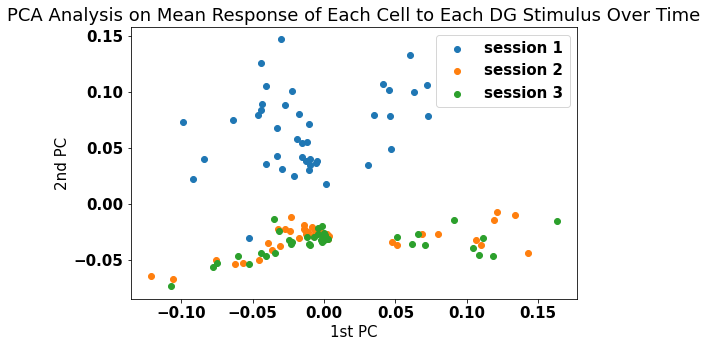

In [27]:
# PCA Model: 2D Visualization
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(transformed_data_pca[transformed_data_pca.Session=="1"][0], transformed_data_pca[transformed_data_pca.Session=="1"][1], label="session 1")
ax.scatter(transformed_data_pca[transformed_data_pca.Session=="2"][0], transformed_data_pca[transformed_data_pca.Session=="2"][1], label="session 2")
ax.scatter(transformed_data_pca[transformed_data_pca.Session=="3"][0], transformed_data_pca[transformed_data_pca.Session=="3"][1], label="session 3")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_title("PCA Analysis on Mean Response of Each Cell to Each DG Stimulus Over Time")
plt.legend(loc="upper right")
plt.show()


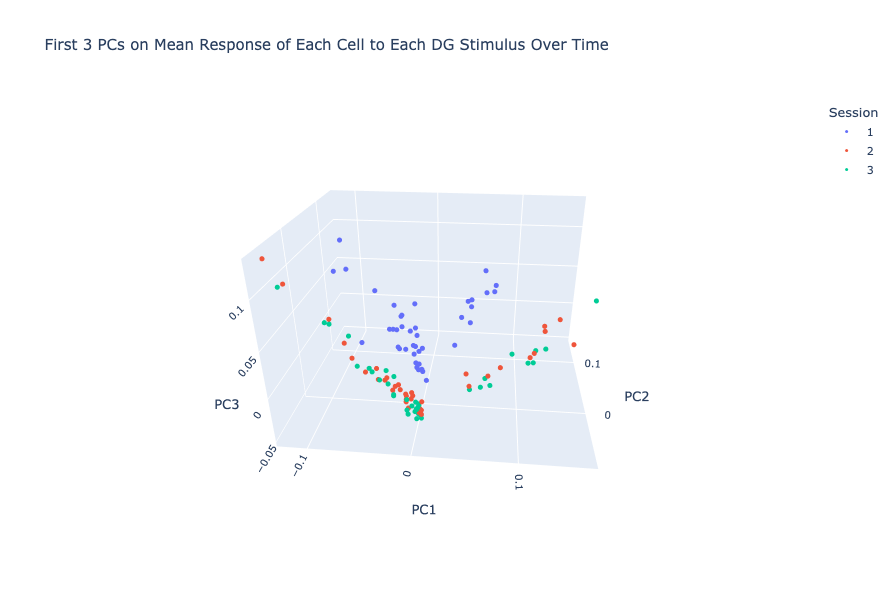

In [28]:
# PCA Model: 3D Visualization
fig = px.scatter_3d(transformed_data_pca, x=0, y=1, z=2, color="Session", labels = {"0": "PC1","1": "PC2", "2": "PC3"}, title = "First 3 PCs on Mean Response of Each Cell to Each DG Stimulus Over Time")
fig.update_traces(marker_size=3) # reduce size of scatter points from default size
fig.update_layout(width=800, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye= dict(x=0.2, y=-2.0, z=1)) # adjust plot appearance
fig.show()

In [ ]:
# Static gratings

In [29]:
# Get response matrics
response1, response2, response3, sg1_responses_by_stimulus, sg2_responses_by_stimulus, sg3_responses_by_stimulus = get_all_relevant_tables_dg_sg_ns(688678764, "static_gratings")

In [37]:
# Transform data for PCA n=3
transformed_data_sg = pca_transform_data(sg1_responses_by_stimulus, sg2_responses_by_stimulus, sg3_responses_by_stimulus, 3)

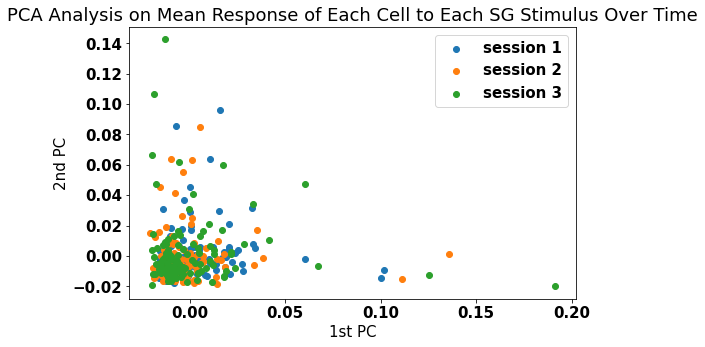

In [40]:
# PCA Model: 2D Visualization
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(transformed_data_sg[transformed_data_sg.Session=="1"][0], transformed_data_sg[transformed_data_sg.Session=="1"][1], label="session 1")
ax.scatter(transformed_data_sg[transformed_data_sg.Session=="2"][0], transformed_data_sg[transformed_data_sg.Session=="2"][1], label="session 2")
ax.scatter(transformed_data_sg[transformed_data_sg.Session=="3"][0], transformed_data_sg[transformed_data_sg.Session=="3"][1], label="session 3")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_title("PCA Analysis on Mean Response of Each Cell to Each SG Stimulus Over Time")
plt.legend(loc="upper right")
plt.show()


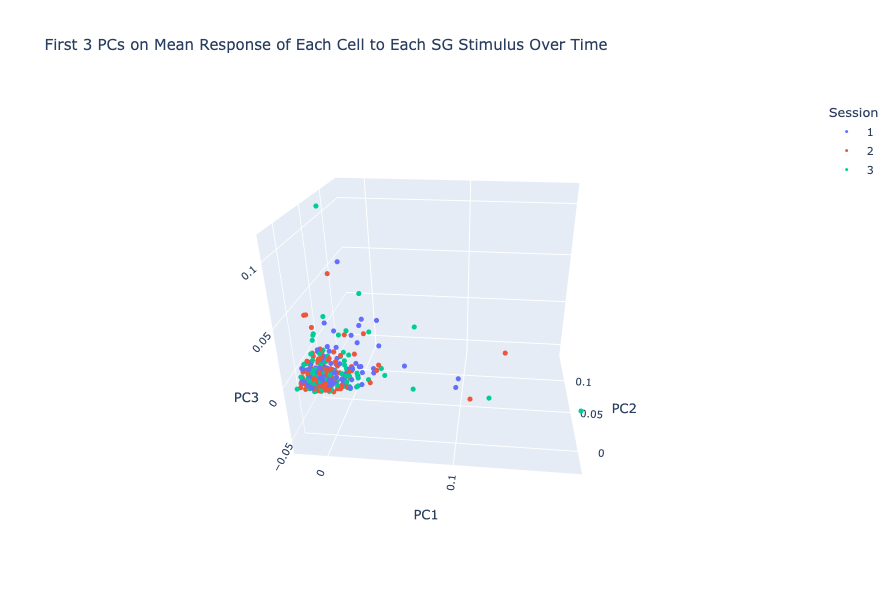

In [41]:
# PCA Model: 3D Visualization
fig = px.scatter_3d(transformed_data_sg, x=0, y=1, z=2, color="Session", labels = {"0": "PC1","1": "PC2", "2": "PC3"}, title = "First 3 PCs on Mean Response of Each Cell to Each SG Stimulus Over Time")
fig.update_traces(marker_size=3) # reduce size of scatter points from default size
fig.update_layout(width=800, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye= dict(x=0.2, y=-2.0, z=1)) # adjust plot appearance
fig.show()

In [ ]:
# Natural Scenes

In [32]:
# Get response matrics
response1, response2, response3, ns1_responses_by_stimulus, ns2_responses_by_stimulus, ns3_responses_by_stimulus = get_all_relevant_tables_dg_sg_ns(688678764, "natural_scenes")

# Transform data for PCA n=3
transformed_data_ns = pca_transform_data(ns1_responses_by_stimulus, ns2_responses_by_stimulus, ns3_responses_by_stimulus, 3)


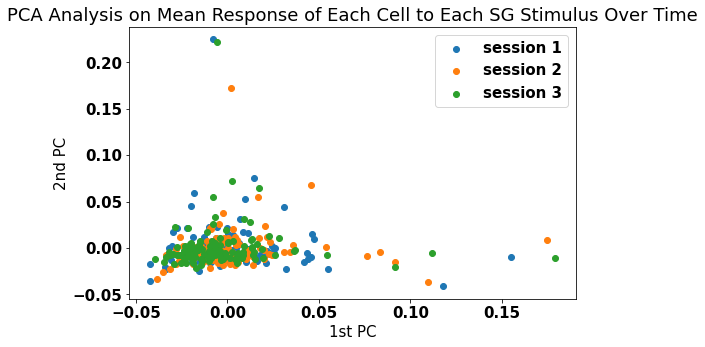

In [35]:
# PCA Model: 2D Visualization
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(transformed_data_ns[transformed_data_ns.Session=="1"][0], transformed_data_ns[transformed_data_ns.Session=="1"][1], label="session 1")
ax.scatter(transformed_data_ns[transformed_data_ns.Session=="2"][0], transformed_data_ns[transformed_data_ns.Session=="2"][1], label="session 2")
ax.scatter(transformed_data_ns[transformed_data_ns.Session=="3"][0], transformed_data_ns[transformed_data_ns.Session=="3"][1], label="session 3")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.set_title("PCA Analysis on Mean Response of Each Cell to Each SG Stimulus Over Time")
plt.legend(loc="upper right")
plt.show()


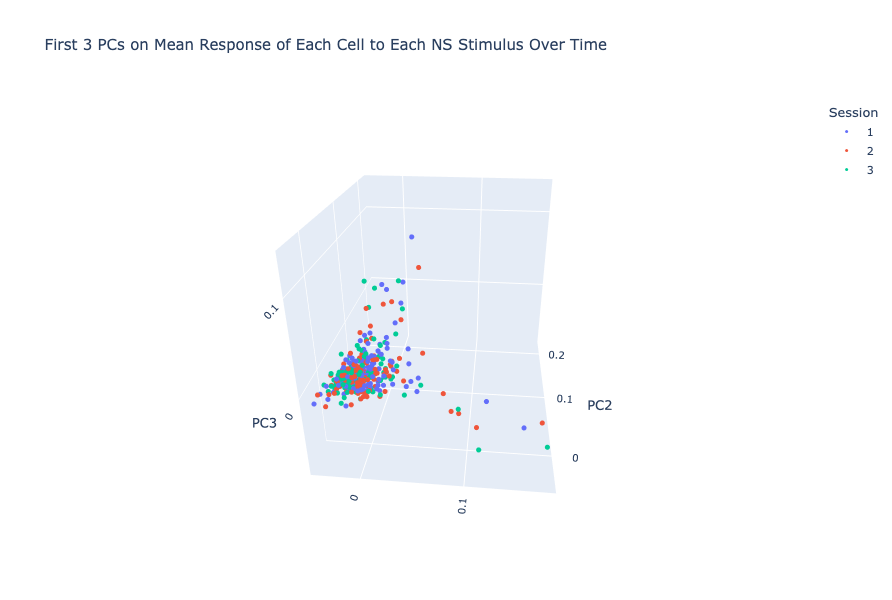

In [42]:
# PCA Model: 3D Visualization
fig = px.scatter_3d(transformed_data_ns, x=0, y=1, z=2, color="Session", labels = {"0": "PC1","1": "PC2", "2": "PC3"}, title = "First 3 PCs on Mean Response of Each Cell to Each NS Stimulus Over Time")
fig.update_traces(marker_size=3) # reduce size of scatter points from default size
fig.update_layout(width=800, height=600, font_size=11, scene_aspectmode="data", scene_camera_eye= dict(x=0.2, y=-2.0, z=1)) # adjust plot appearance
fig.show()